## Optimización del aprendizaje

### Resumen
En este notebook vamos a ver las posibles optimizaciones que podemos hacer para que los modelos aprendan más rápido y sean más robustos.
Vamos a ver:
- CallBacks
- L2 regularización
- Dropout
- Data Augmentation
- Batch Normalization

Utilizaremos el dataset CIFAR 10 para comparar todas las pruebas y ver su eficacia

Importamos los paquetes necesarios

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import tensorflow as tf
from aux_func import show_history, r2_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout

### Big model = overfiting
Veamos que fácil es hacer overfiting con una red neuronal.

Número de elementos en el dataset =  60000


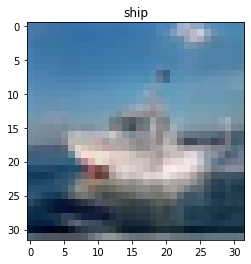

In [3]:
from tensorflow.keras.datasets import cifar10

(X_train_cifar10, y_train_cifar10), (X_validation_cifar10, y_validation_cifar10) = cifar10.load_data()
X_train_cifar10 = X_train_cifar10/255
X_validation_cifar10 = X_validation_cifar10/255

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Número de elementos en el dataset = ',X_train_cifar10.shape[0]+X_validation_cifar10.shape[0])
plt.title(labels[int(y_train_cifar10[62])])
plt.imshow(X_train_cifar10[62])
plt.show()

In [21]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=2000, activation='relu')(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=20,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 4, 4, 100)       

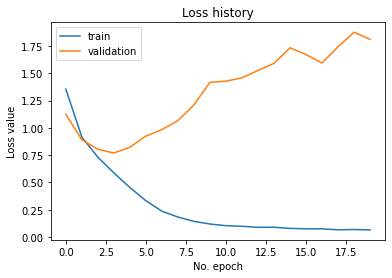

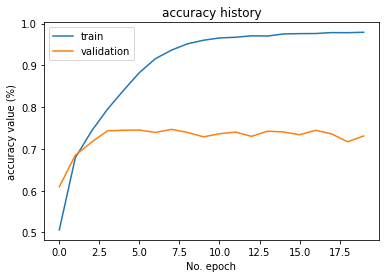

In [22]:
show_history(history)

Claramente a partir de la epoch 5 se está produciendo overfiting y el accuracy en validación está disminuyendo poco a poco.
El score obtenido es 73%

### Small model
Una de las opciones más sencillas es la reducción del tamaño del modelo para limitar su capacidad de aprendizaje.
Con ello podemos reducir la aparición de overfiting.

In [23]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=50, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=20,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 20)        560       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 40)        7240      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 40)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 60)          21660     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 4, 4, 60)        

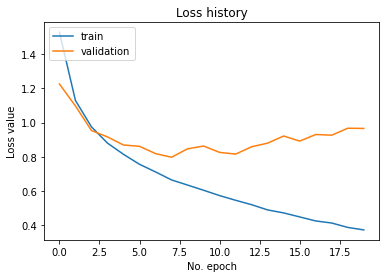

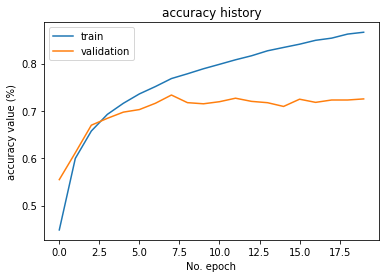

In [24]:
show_history(history)

Se ha conseguido mitigar el overfiting.
El score obtenido es de 72.5%


### Early Stopping
Otra opción sencilla para la mitigación del overfiting es el Early Stopping.
El Early Stopping es un callback que se utiliza durante el entrenamiento.
Dicha función monitoriza el entrenamiento y cuando detecta que el modelo ha dejado de mejorar en el dataset de validación, parará el entrenamiento.
Además, podemos seleccionar que nos devuelva el modelo que mejor val_score haya obtenido durante el entrenamiento.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=30,
                    validation_data=(X_validation_cifar10, y_validation_cifar10), callbacks=[early_stopping])

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 4, 4, 100)       

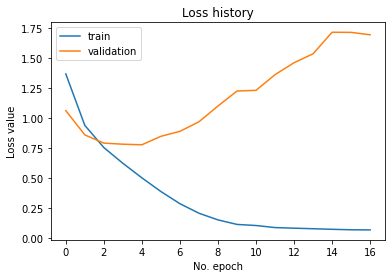

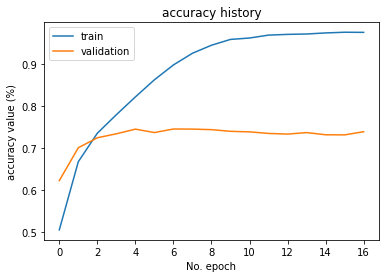

In [28]:
show_history(history)

El Early Stopping ha parado el entrenamiento cuando ha detectado overfiting.
El método fit nos ha devuelto el modelo que tiene mejor score.

In [30]:
print("Evaluate on validation data")
results = model.evaluate(X_validation_cifar10, y_validation_cifar10, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

Evaluate on validation data
79/79 [==============================] - 0s 2ms/step - loss: 0.8901 - accuracy: 0.7460
val loss: 0.8900617957115173 val acc: 0.7459999918937683


Hemos obtenido un 74.5% de score

### Regularización L2
En las capas que deseemos podemos introducir una regularización L2 para impedir que se produzca el overfiting.
La regularización L2 introduce una restricción en los pesos de la red. Cuanto mayor es la constante de regularización mayor es dicha restricción.
Cuando el modelo sea entrenado, mejorará la función loss y reducirá el tamaño de los pesos.

In [32]:
from tensorflow.keras.regularizers import l2

# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu', kernel_regularizer=l2(0.001))(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=30,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 4, 4, 100)       

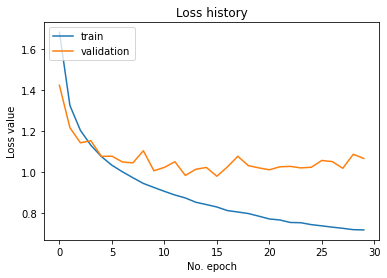

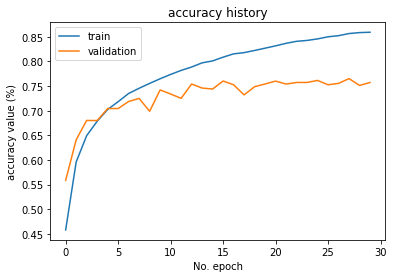

In [33]:
show_history(history)

El overfiting claramente se ha eliminado sin pérdida de eficacia del modelo.
¿Qué pasa si ponemos una regularización L2 con constante 1?
Observar las diferencias en loss con y sin regularización durante el training.
Hemos obtenido un score de 75.7% de score.

### Dropout
Podemos introducir en distintas partes de la red las capas dropout para apagar de manera aleatoria las neuronas y así impedir que se produzca overfiting.
Cuanto mayor es el ratio de dropout mayor será la regularización.
No es necesario introducir las capas dropout en todas las capas de la red.

In [40]:
from tensorflow.keras.layers import Dropout

# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dropout(0.7)(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=30,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 4, 4, 100)       

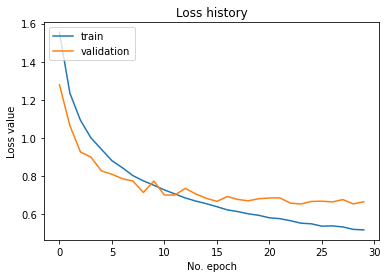

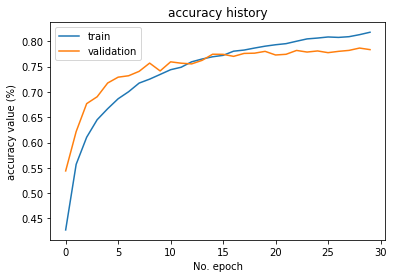

In [41]:
show_history(history)

Conseguimos eliminar el overfiting y obtenemos un score muy alto, 78.3% de accuracy.

### Data Augmentation
El data augmentation es uno de los mejores métodos de regularización.
Consigue aumentar virtualmente el dataset haciendo que el modelo sea muy robusto y que su performance en validation sea muy buena.
Con ello conseguimos reducir el overfiting y además que el modelo sea robusto frente a pequeñas perturbaciones en las imágenes.
Vamos a implementar un data augmentation que se aplicará durante el entrenamiento, para ello usaremos la clase tensorflow.data.Dataset.
Las funciones que vamos a usar son propias de tensorflow, con ello aseguramos un máximo rendimiento y fiabilidad del entrenamiento.
También se puede implementar usando generadores o con un generador de keras.

2021-12-16 19:41:00.557424: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-16 19:41:00.579759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 19:41:00.580430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.835GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-16 19:41:00.580447: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-16 19:41:00.581712: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-16 19:41:00.582871: I tensorflow/stream_executor/platform/d

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


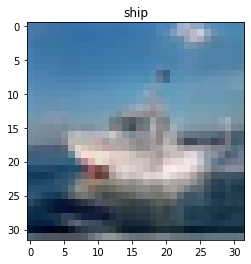

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


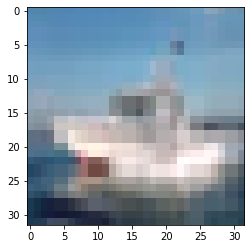

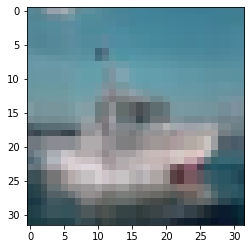

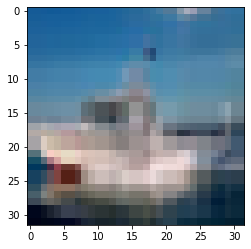

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


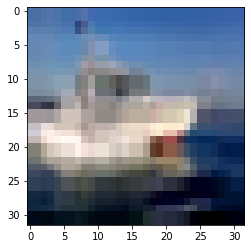

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


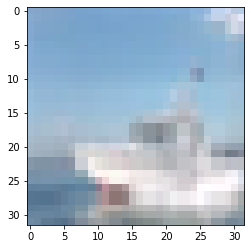

In [4]:
from tensorflow.data import Dataset

# Creamos un Dataset utilizando numpys
train_ds = Dataset.from_tensor_slices((X_train_cifar10, y_train_cifar10))
val_ds = Dataset.from_tensor_slices((X_validation_cifar10, y_validation_cifar10))

# Seleccionamos el batch_size que
batch_size = 50

# Creamos una función que perturbará de forma aleatoria las imágenes.
# Las etiquetas quedan invariantes
def processing_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.resize(image, (40,40), method='nearest',antialias=False)
    image = tf.image.random_crop(image, (32,32,3))
    return image, label


# Esta función hará las modificaciones pertinentes al dataset para poder usarlo durante el entrenamiento
def data_aug(ds: Dataset, shuffle=False, augment=False):
    # Hacemos que el dataset se repita de manera indefinida
    ds = ds.repeat()

    # Aleatorizamos el dataset usando un buffer de 5000
    if shuffle:
        ds = ds.shuffle(5000)

    # Aplicamos las transformaciones pertinentes
    if augment:
        ds = ds.map(processing_data,num_parallel_calls=4)

    # Hacemos que el dataset este formado por batches
    ds = ds.batch(batch_size)

    # Devolvemos el dataset precargándolo
    return ds.prefetch(buffer_size=4)

# Aplicamos la función data_aug a nuestro dataset
train_ds = data_aug(train_ds, shuffle=True, augment=True)
# Al dataset de validación no le aplicamos perturbaciones
val_ds = data_aug(val_ds)


# Visualizemos unos ejemplos de como la función processing_data modifica las imágenes
plt.title(labels[int(y_train_cifar10[62])])
plt.imshow(X_train_cifar10[62])
plt.show()
for _ in range(5):
    image_mod = np.array(processing_data(X_train_cifar10[62], 0)[0])
    plt.imshow(image_mod)
    plt.show()


In [30]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Usamos los dataset creados con tensorflow.data.Dataset para entrenar nuesto modelo
history = model.fit(train_ds, batch_size=50, epochs=30,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=200)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 100)       

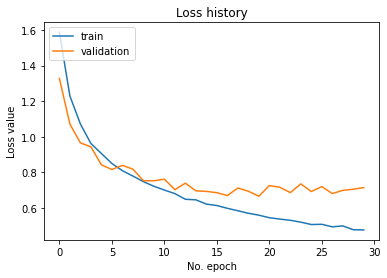

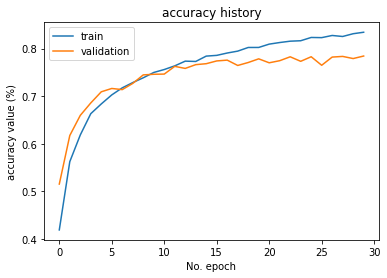

In [31]:
show_history(history)

Claramente se ha reducido el overfiting y hemos obtenido unos buenos resultados durante el entrenamiento.
Hemos obtenido un score de 78.4%

### Batch size correcto
Con el Batch size modificamos:
- La calidad de aprendizaje
- La velocidad de aprendizaje
- La duración del aprendizaje

Por tanto es importante seleccionar un buen Batch Size para que el entrenamiento sea lo más eficiente posible.
En muchas ocasiones el tamaño del Batch Size está limitado superiormente por la memoria de la GPU que estemos usando. En muchos modelos el Batch Size que podemos usar es menor a 5.

In [19]:
scores = []
epochs_train = []
for bs in range(1,30):
    # capas de la red
    input = Input(shape=(32,32,3))
    layer = input
    layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Flatten()(layer)
    layer = Dense(units=1000, activation='relu')(layer)
    output = Dense(units=10, activation='softmax')(layer)

    # creamos el modelo
    model = Model(inputs=input, outputs=output)
    print(model.summary())

    # optimizador
    optimizer = Adam(learning_rate=0.001)

    # función loss
    loss = SparseCategoricalCrossentropy(from_logits=False)

    # métrica
    metrics = ['accuracy']

    # compilamos el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

    history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=bs, epochs=30,
                    validation_data=(X_validation_cifar10, y_validation_cifar10), callbacks=[early_stopping])
    scores.append(model.evaluate(X_validation_cifar10, y_validation_cifar10, batch_size=128)[1])
    epochs_train.append(len(history.history['loss']))


Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 8, 8, 100)         45100     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 4, 4, 100)       

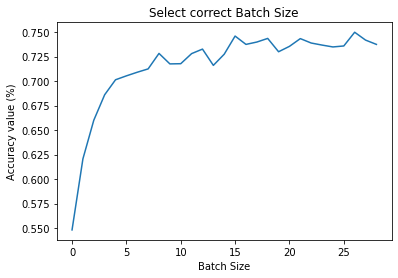

In [20]:
plt.plot(scores)
plt.title('Select correct Batch Size')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Batch Size')
plt.show()

Claramente observamos que deberíamos elegir un Batch Size mayor de 30

### Batch Normalization
Podemos añadir capas de Batch Normalization en cualquier parte de la red excepto en la última.
Con ello conseguimos que en todo momento los inputs de las layers estén en los rangos deseados.
Veamos un ejemplo de red profunda sin BN

In [52]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
for _ in range(20):
    layer = Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=5,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 32, 32, 10)        280       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 32, 32, 10)        910       
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 32, 32, 10)        910       
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 32, 32, 10)        910       
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 32, 32, 10)        910       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 32, 32, 10)     

Claramente el modelo no aprende nada ya que el gradiente no se ha podido propagar a través de las capas.
Probemos ahora añadiendo capas de BN.

In [13]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
for _ in range(20):
    layer = Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=20,
                    validation_data=(X_validation_cifar10, y_validation_cifar10))

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 10)        910       
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 10)        40        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 10)        910       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 10)      

En este caso el modelo se ha entrenado correctamente, obteniendo un score de 71.3%.

### Seleccionar tamaño correcto del modelo
En muchas ocasiones es preferible tener un modelo de peor calidad pero que sea más rápido y de menor tamaño.
Veamos como varía la velocidad de predicción vs el tamaño del modelo

In [3]:
time_prediction = []
scores = []
for neuronas in range(1,75):
    # capas de la red
    input = Input(shape=(32,32,3))
    layer = input
    layer = Conv2D(filters=neuronas, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=neuronas*2, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=neuronas*2, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Flatten()(layer)
    layer = Dense(units=neuronas*40, activation='relu')(layer)
    output = Dense(units=10, activation='softmax')(layer)

    # creamos el modelo
    model = Model(inputs=input, outputs=output)
    print(model.summary())

    # optimizador
    optimizer = Adam(learning_rate=0.001)

    # función loss
    loss = SparseCategoricalCrossentropy(from_logits=False)

    # métrica
    metrics = ['accuracy']

    # compilamos el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

    history = model.fit(x=X_train_cifar10, y=y_train_cifar10, batch_size=50, epochs=30,
                        validation_data=(X_validation_cifar10, y_validation_cifar10), callbacks=[early_stopping])

    t1 = time()
    # hacemos varias predicciones para calcular los tiempos de ejecución
    for _ in range(10):
        model.evaluate(X_validation_cifar10, y_validation_cifar10, batch_size=1000)
    scores.append(model.evaluate(X_validation_cifar10, y_validation_cifar10, batch_size=1000)[1])
    time_prediction.append(time()-t1)

2021-12-16 16:18:49.218570: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-16 16:18:49.242281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 16:18:49.242954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.835GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-16 16:18:49.242978: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-16 16:18:49.243880: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-16 16:18:49.245380: I tensorflow/stream_executor/platform/d

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 1)         28        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 2)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 2)           38        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 2)          

2021-12-16 16:18:50.792858: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-16 16:18:51.008102: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


 993/1000 [============================>.] - ETA: 0s - loss: 1.9688 - accuracy: 0.2739WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8c0ff220e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1000/1000 [==============================] - 2s 2ms/step - loss: 1.9683 - accuracy: 0.2742 - val_loss: 1.8286 - val_accuracy: 0.3286
Epoch 2/30

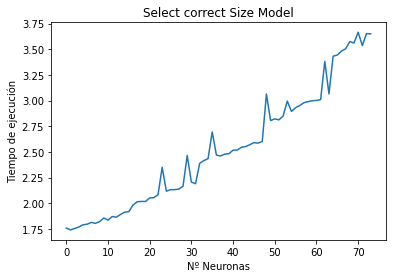

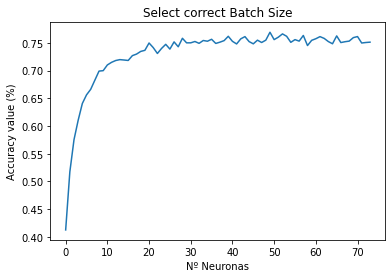

In [4]:
plt.plot(time_prediction)
plt.title('Select correct Size Model')
plt.ylabel('Tiempo de ejecución')
plt.xlabel('Nº Neuronas')
plt.show()

plt.plot(scores)
plt.title('Select correct Batch Size')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Nº Neuronas')
plt.show()

### Combinación de varias optimizaciones
Vamos a probar a utilizar varias de las optimizaciones vistas

In [13]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=200, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=2000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_ds, batch_size=50, epochs=100,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=200)

Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 32, 32, 50)        1400      
_________________________________________________________________
max_pooling2d_237 (MaxPoolin (None, 16, 16, 50)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 50)        200       
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 16, 16, 100)       45100     
_________________________________________________________________
max_pooling2d_238 (MaxPoolin (None, 8, 8, 100)         0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 100)      

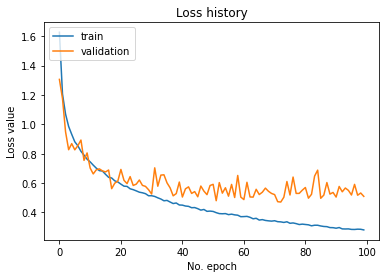

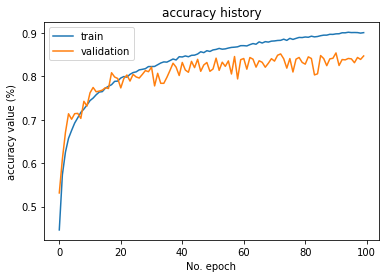

In [14]:
show_history(history)

Hemos obtenido un modelo robusto, sin overfiting y con un score de 85%

### Reduce LR on Plateau
Durante los entrenamiento podemos usar otro callback llamado Reduce LR on Plateau.
Con dicha función podemos hacer que durante el entrenamiento el LR se reduzca por un factor para hacer que el modelo converja más rápido.

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=200, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=2000, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, mode='max')

history = model.fit(train_ds, batch_size=50, epochs=100,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=100, callbacks=[reduce_lr])

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 50)        1400      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 50)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 16, 50)        200       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 100)       45100     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 100)         0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 8, 8, 100)       

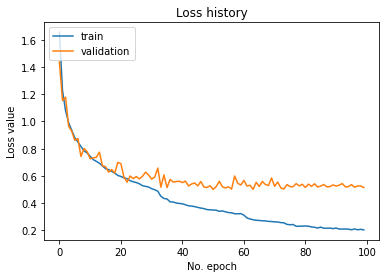

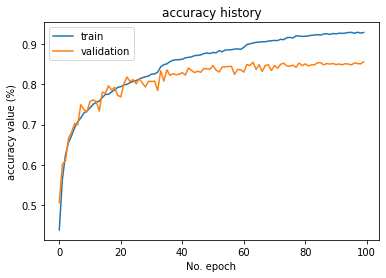

In [17]:
show_history(history)

Si comparamos esta grafica con la anterior, podemos ver que el validation_accuracy es mucho mas estable usando Reduce LR.

### Practica 3
Usando el dataset CIFAR 100:
- Implementar una red convolucional con las optimizaciones vistas para obtener el mejor score posible.